## Final Project Submission

Please fill out:
* Student name: FRANCIS MUTHONI
* Student pace: HYBRID 
* Scheduled project review date/time: 
* Instructor name: ANTONNY MUIKO
* Blog post URL:


## 1. Business Understanding 


My company has noticed that major corporations are producing original video content and wants to join the trend by launching a new movie studio. However, we lack expertise in film production. I have been tasked with researching the types of films that are currently performing well at the box office. My goal is to transform these findings into actionable insights to guide the head of our new movie studio in deciding which types of films to produce.

## 1.1 Objectives of the Research:



1. Identify the highest-grossing films.
2. Determine the most common genres among top-grossing movies.
3. Analyze the correlation between box office performance and movie ratings.
4. Identify the most successful film studios.
These insights will guide recommendations on the types of films our company should focus on creating.

## 2. Data Understanding 

In [52]:
# import the necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [53]:
# connecting to sqlite database
path= r"C:\Users\USER\Documents\Moringa_Labs\Final_Phase_2_Project\Movie_Production_Analysis_Phase_2_Project\zippedData\im.db"
conn = sqlite3.connect(path)

In [54]:
#r reading from the data base to understand the tables
pd.read_sql("""
            SELECT *
            FROM sqlite_master 
            WHERE type = "table"
""",conn

)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [55]:
# reading box office csv
movie_gross_path=r"C:\Users\USER\Documents\Moringa_Labs\Final_Phase_2_Project\Movie_Production_Analysis_Phase_2_Project\zippedData\bom.movie_gross.csv.gz"
movie_gross_df = pd.read_csv(movie_gross_path)
movie_gross_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


## 2.1 Exploring the Data

### 2.1.0 Exploring the sqlite database


In [56]:
# reading the movie basics table
movie_basic_df=pd.read_sql("""
            SELECT * 
            FROM movie_basics

""", conn)

In [57]:
# reading the movie ratings table
movie_ratings_df=pd.read_sql("""
            SELECT * 
            FROM movie_ratings

""", conn)

### 2.1.1 Exploring the csv data


In [58]:
# summary info
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [59]:
# dafaframe description
movie_gross_df.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [60]:
# display size of the dataset 
movie_gross_df.shape

(3387, 5)

In [61]:
# displaying the columns
movie_gross_df.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [62]:
# displaying the first 5 rows
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


## 2.2 DATA PREPARATION

### 2.2.1 Data Cleaning for bom_movie_gross_csv

In [63]:
# checking for missing values in the dataframe
movie_gross_df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [64]:
# Fill null values in the 'studio' column with "Unknown"
movie_gross_df['studio'].fillna('Unknown', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_1152\4176603422.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_gross_df['studio'].fillna('Unknown', inplace=True)


In [65]:
movie_gross_df.isnull().sum()

title                0
studio               0
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [66]:
# filling in missing values in domestic gross using median
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross'].fillna(movie_gross_df['domestic_gross'].median())

In [67]:
movie_gross_df.isnull().sum()

title                0
studio               0
domestic_gross       0
foreign_gross     1350
year                 0
dtype: int64

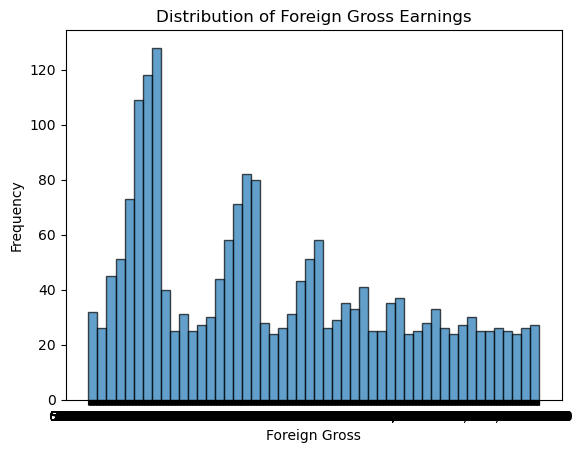

count        2037
unique       1204
top       1200000
freq           23
Name: foreign_gross, dtype: object


In [68]:
# Plot the distribution of foreign_gross
plt.hist(movie_gross_df['foreign_gross'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Foreign Gross Earnings')
plt.xlabel('Foreign Gross')
plt.ylabel('Frequency')
plt.show()

# Print summary statistics
print(movie_gross_df['foreign_gross'].describe())

From the distribution our foreign data is right skewed thus using median to fill the null values is the right option since its not affectred by the outliers
Lets go ahead and execute that

In [69]:
# Remove commas and convert to numeric for foreign_gross
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',', '')
# Change the data type to float
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype(float)
# Fill missing foreign_gross values with the median
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(movie_gross_df['foreign_gross'].median())

In [70]:
movie_gross_df.isnull().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [71]:

movie_gross_df['foreign_gross'].isnull().sum()

0

In [72]:
# checking null
movie_gross_df.isnull().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [73]:
# displaying last 1000
movie_gross_df['foreign_gross'].tail(1000)

2387    60400000.0
2388    79400000.0
2389    64000000.0
2390    39400000.0
2391    57800000.0
           ...    
3382    18700000.0
3383    18700000.0
3384    18700000.0
3385    18700000.0
3386    18700000.0
Name: foreign_gross, Length: 1000, dtype: float64

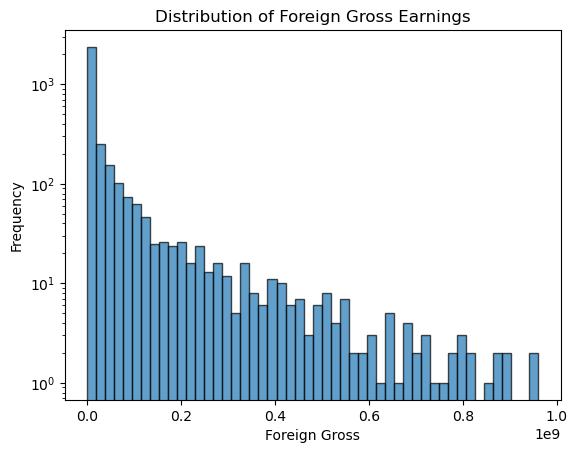

count    3.387000e+03
mean     5.248329e+07
std      1.100461e+08
min      6.000000e+02
25%      1.160000e+07
50%      1.870000e+07
75%      2.915000e+07
max      9.605000e+08
Name: foreign_gross, dtype: float64


In [74]:
# Plot the distribution of foreign_gross
plt.hist(movie_gross_df['foreign_gross'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Foreign Gross Earnings')
plt.xlabel('Foreign Gross')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Print summary statistics
print(movie_gross_df['foreign_gross'].describe())

Replacing the missing values in the foreign_gross column with the median does not alter the overall distribution of the data, thus preserving its accuracy.

In [75]:
# checking for duplicates
movie_gross_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3382    False
3383    False
3384    False
3385    False
3386    False
Length: 3387, dtype: bool

### 2.2.2 Data Cleaning for im.db

#### 2.2.2.1 Exploring Movie_Ratings_df

In [76]:

movie_ratings_df

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [77]:
# descriptive analysis
movie_ratings_df.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [78]:
# checking info
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [79]:
# checking for the null values
movie_ratings_df.isnull().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

In [80]:
# checking the shape
movie_ratings_df.shape

(73856, 3)

In [81]:
# checking duplicates
movie_ratings_df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
73851    False
73852    False
73853    False
73854    False
73855    False
Length: 73856, dtype: bool

The above dataframe doesnt have null values thus its ready to be used in future analysis

#### 2.2.2.2 Exploring Movie_Basics_df

In [82]:
movie_basic_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [83]:
# checking info
movie_basic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [84]:
# descriptive analysis
movie_basic_df.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [85]:
# checking the shape
movie_basic_df.shape

(146144, 6)

In [86]:
# checking duplicates
movie_basic_df.duplicated().sum()

0

In [87]:
# checking for the null values
movie_basic_df.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [88]:
# checking the percentage of null values
(movie_basic_df.isnull().sum()/len(movie_basic_df))*100

movie_id            0.000000
primary_title       0.000000
original_title      0.014369
start_year          0.000000
runtime_minutes    21.717621
genres              3.700460
dtype: float64

From the percentages above I chose to drop null values in original title and genres columns sinmce they are insignificant to our analysis
Runtime_Minutes column requires data cleaning.
Lets dive into it

In [89]:
# Dropping rows with insignificant null values
movie_basic_df = movie_basic_df.dropna(subset=["genres","original_title"])

In [90]:
# checking for the null values
movie_basic_df.isnull().sum()

movie_id               0
primary_title          0
original_title         0
start_year             0
runtime_minutes    28502
genres                 0
dtype: int64

In [91]:
# reading the runtime_minutes column
movie_basic_df["runtime_minutes"]

0         175.0
1         114.0
2         122.0
3           NaN
4          80.0
          ...  
146138      NaN
146139    123.0
146140      NaN
146141      NaN
146143      NaN
Name: runtime_minutes, Length: 140734, dtype: float64

In [92]:
# filling the null in runtime_minutes column with median
movie_basic_df['runtime_minutes'] = movie_basic_df['runtime_minutes'].fillna(movie_basic_df['runtime_minutes'].median())

C:\Users\USER\AppData\Local\Temp\ipykernel_1152\3978300453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_basic_df['runtime_minutes'] = movie_basic_df['runtime_minutes'].fillna(movie_basic_df['runtime_minutes'].median())


In [93]:
movie_basic_df.isnull().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

Saving the cleaned data into CSV for visualisation purposes

In [94]:

# Save cleaned DataFrames to csv
movie_gross_df.to_csv('cleaned_movie_gross_df', index=False)
movie_basic_df.to_csv('cleaned_movie_basics_df', index=False)
movie_ratings_df.to_csv('cleaned_movie_ratings_df', index=False)

In [95]:
# Merge movie_ratings_df with movie_basic_df on 'movie_id'
merged_df = pd.merge(movie_ratings_df, movie_basic_df, on='movie_id', how='inner')
merged_df

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,tt1060240,6.5,21,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"
...,...,...,...,...,...,...,...,...
73047,tt9805820,8.1,25,Caisa,Caisa,2018,84.0,Documentary
73048,tt9844256,7.5,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi"
73049,tt9851050,4.7,14,Sisters,Sisters,2019,87.0,"Action,Drama"
73050,tt9886934,7.0,5,The Projectionist,The Projectionist,2019,81.0,Documentary


In [96]:
# merged csv 
merged_df.to_csv('merged_df', index=False)

In [97]:
# Merge movie_ratings_df with bom movie gross db on 'movie_id'
Final_merged_df = pd.merge(merged_df, movie_gross_df, left_on='primary_title', right_on='title', how='inner')
Final_merged_df

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",The Legend of Hercules,LG/S,18800000.0,42400000.0,2014
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,Baggage Claim,FoxS,21600000.0,887000.0,2013
2,tt1181840,7.0,5494,Jack and the Cuckoo-Clock Heart,Jack et la mécanique du coeur,2013,94.0,"Adventure,Animation,Drama",Jack and the Cuckoo-Clock Heart,Shout!,1400000.0,3400000.0,2014
3,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",Moneyball,Sony,75600000.0,34600000.0,2011
4,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",Hereafter,WB,32700000.0,72500000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,tt7122852,5.1,7,Let Me In,Let Me In,2017,74.0,Horror,Let Me In,Over.,12100000.0,12000000.0,2010
3016,tt7315484,5.2,22399,The Silence,The Silence,2019,90.0,"Horror,Thriller",The Silence,MBox,100000.0,132000.0,2013
3017,tt8011712,7.4,54,The Past,The Past,2018,120.0,"Drama,Horror",The Past,SPC,1300000.0,9300000.0,2013
3018,tt9042690,7.6,43,The Negotiation,The Negotiation,2018,89.0,"Documentary,History,War",The Negotiation,CJ,111000.0,18700000.0,2018


In [98]:
# Verify that there are no more null values
print(Final_merged_df.isnull().sum())

movie_id           0
averagerating      0
numvotes           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
title              0
studio             0
domestic_gross     0
foreign_gross      0
year               0
dtype: int64


After merging, the columns primary_title, original_title, and title contain equivalent values. Therefore, we will drop the primary_title and original_title columns

In [99]:

#dropping primary_title,original_title
Final_merged_df.drop(columns = ['primary_title','original_title'], inplace=True)

In [100]:
# Save the cleaned merged DataFrame to a new CSV file
Final_merged_df.to_csv('cleaned_merged_movie_data.csv', index=False)